In [ ]:
# Delete and make these folders before starting - debug, artifacts

import json
import pickle
import time
import datetime
import logging

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
import torchvision as tv
from torch.optim import Adam

import get_data_loaders, get_Image_Transform_Network, get_VGG_network, utils

now= datetime.datetime.now()

#To compare across results
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

TRAIN_IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4

# Can re_size to the size you want 
# utils.convert_to_size_and_save("language_of_stone.jpg", "language_of_stone_256.jpg", img_size= (256,256))
# TRAIN_STYLE_IMAGE = "language_of_stone_256.jpg"
# Or use the image as it is, the model will do a centre crop of TRAIN_IMAGE_SIZE later
TRAIN_STYLE_IMAGE = "language_of_stone.jpg"

# Can adjust scaling factor later to tune further
scale_factor = [1.]
LEARNING_RATE = 0.001*scale_factor[0]

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}


#Loading pickled dataloader
try:
    with open('dataloader_pickled.pickle', 'rb') as f:
        test_train_loader = pickle.load(f)
except:
    #Using COCO dataset. Use the first time, and then pickle it 
    train_loader = get_data_loaders.get_classic_dataset(image_size=TRAIN_IMAGE_SIZE, batch_size= BATCH_SIZE)
    #Pickling
    test_train_loader = get_data_loaders.get_classic_dataset()
    with open("dataloader_pickled.pickle","wb") as f:
        pickle.dump(test_train_loader,f, protocol=pickle.HIGHEST_PROTOCOL)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    vgg_network = get_VGG_network.VGGNetwork()
    vgg_network.eval()
    vgg_network.to(device)

style_img_tensor = utils.get_batch_tensor_from_image(image=TRAIN_STYLE_IMAGE, image_size=TRAIN_IMAGE_SIZE, device=device) #[1,3, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE]

# The network to be trained. Two variants are available - padded one, and no padding one
test_net = get_Image_Transform_Network.RTST_ImgTfNetPadding()
test_net.train()
optimizer = Adam(test_net.parameters(), LEARNING_RATE)

test_vgg_network = vgg_network
mse_loss = nn.MSELoss()

with torch.no_grad():
    style_loss_features = test_vgg_network(style_img_tensor)
    gram_style = [utils.gram_matrix(y) for y in style_loss_features]
    
    
#Experimental Weights
TV_REG_WEIGHT = 1e-6  #order of 1e-5: 1e-6 don't want the pixel loss to impact the stylization too much
STYLE_LOSS_WEIGHTS = [1e5, 1e5, 1e5, 1e5] #change and experiment for different layers
CONTENT_LOSS_WEIGHT = 1.

In [6]:
#Clean up train

def train(starts_at=0,steps=100, PRINT_FREQUENCY=10,SAVE_FREQUENCY = 200, cost_curves_filename = "./artifacts/loss_details_per_epoch.txt"):
    test_net.train()
    count = starts_at
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    
    while True:
        for x, _ in test_train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = test_net(x)            
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = test_vgg_network(y)
            features_xc = test_vgg_network(xc)

            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_LOSS_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = TV_REG_WEIGHT * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_LOSS_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = utils.gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss + reg_loss 
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss
            
            loss_dict = {"epoch":count,
                         "agg_content_loss": agg_content_loss.item()/10,
                         "agg_style_loss": agg_style_loss.item()/10,
                         "agg_reg_loss": agg_reg_loss.item()/10,
                         "total_loss": (agg_content_loss.item() +agg_style_loss.item() +agg_reg_loss.item() )/ 10}
            
            if count % PRINT_FREQUENCY == 0:
                time_stamp = now.strftime("%H:%M:%S")
                message = f"{time_stamp} {count}/{steps} Content Loss: {agg_content_loss / 10:.2f}  Style Loss: {agg_style_loss / 10:.2f}  Reg Loss: {agg_reg_loss / 10:.2f} Total Loss: {(agg_content_loss + agg_style_loss + agg_reg_loss ) / 10:.6f}"
                
                #Write losses to a txt file for plotting cost curves later
                with open(cost_curves_filename,"a") as f:             
                    f.write(str(loss_dict)+"\n")
          
                print(message)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                
                #change to eval mode before saving a few intermediate results
                test_net.eval()
                y = test_net(x) #
                
                #Save model every SAVE_FREQUENCY batches
                if count%SAVE_FREQUENCY==0:
                    torch.save(test_net.state_dict(), f"./artifacts/saved_model_{count}")
                    current_time = now.strftime("%H:%M:%S")
                    utils.save_debug_image(x, y.detach(), f"./debug/{count}_{current_time}.png")
                
                test_net.train()
                
                if count>=steps:
                    return
            

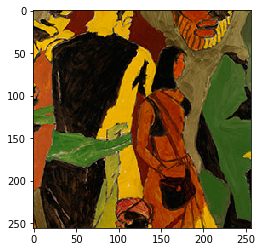

In [7]:
plt.show()
plt.imshow(utils.get_numpy_image_to_plot(style_img_tensor.cpu().detach().numpy())[0])

In [8]:
train(0,100)

17:50:56 10/100 Content Loss: 14.52  Style Loss: 21.73  Reg Loss: 1.07 Total Loss: 37.323040
17:50:56 20/100 Content Loss: 14.52  Style Loss: 19.93  Reg Loss: 1.07 Total Loss: 35.515244
17:50:56 30/100 Content Loss: 14.73  Style Loss: 20.42  Reg Loss: 1.07 Total Loss: 36.220421
17:50:56 40/100 Content Loss: 14.61  Style Loss: 19.79  Reg Loss: 1.08 Total Loss: 35.477020
17:50:56 50/100 Content Loss: 14.66  Style Loss: 19.22  Reg Loss: 1.06 Total Loss: 34.934994
17:50:56 60/100 Content Loss: 14.41  Style Loss: 18.05  Reg Loss: 1.07 Total Loss: 33.531307
17:50:56 70/100 Content Loss: 14.28  Style Loss: 18.20  Reg Loss: 1.06 Total Loss: 33.544842
17:50:56 80/100 Content Loss: 14.21  Style Loss: 17.44  Reg Loss: 1.07 Total Loss: 32.715904
17:50:56 90/100 Content Loss: 14.58  Style Loss: 16.78  Reg Loss: 1.08 Total Loss: 32.431149
17:50:56 100/100 Content Loss: 14.51  Style Loss: 17.32  Reg Loss: 1.09 Total Loss: 32.928883


In [ ]:
train(100,30000)

In [ ]:
train(30000,30100)

In [ ]:
train(30100,30200)

In [ ]:
# Model saving,reloading

#torch.save(test_net.state_dict(), "saved_model")

# the_model = TheModelClass(*args, **kwargs)
# the_model.load_state_dict(torch.load(PATH))

In [ ]:
#for testing
for x, _ in test_train_loader:
    test_new_content = x.to(device)
    break

img_output = test_net(test_new_content)
plt.imshow(utils.get_numpy_image_to_plot(test_new_content.cpu().detach().numpy())[0])

In [ ]:
plt.imshow(utils.get_numpy_image_to_plot(img_output.cpu().detach().numpy())[0])

In [ ]:
history = utils.post_processing()

In [ ]:
history[3019]